In [42]:
import pandas as pd
from operator import attrgetter
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
from scipy import stats
import pingouin as pg
from scipy.stats import mannwhitneyu
import warnings
import seaborn as sns
from operator import attrgetter
import matplotlib.colors as mcolors
from datetime import datetime
from tqdm.auto import tqdm
from scipy.stats import norm


# Задание 1. 
Написать функцию для расчета ретеншн

сначала нужно разобраться с тем, в каком состоянии данные

In [3]:
reg_data = pd.read_csv('problem1-reg_data.csv', sep=';')
auth_data =pd.read_csv( 'problem1-auth_data.csv', sep=';')

In [4]:
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [4]:
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [6]:
reg_data.shape

(1000000, 2)

In [7]:
reg_data.reg_ts.nunique() 

1000000

In [8]:
auth_data.shape

(9601013, 2)

In [10]:
reg_data.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [12]:
reg_data.dtypes

reg_ts    int64
uid       int64
dtype: object

In [13]:
auth_data.dtypes

auth_ts    int64
uid        int64
dtype: object

In [14]:
reg_data.describe()

,reg_ts,uid
count,1.000000e+06,1.000000e+06
mean,1.548332e+09,5.552354e+05
std,5.253653e+07,3.206011e+05
min,9.113822e+08,1.000000e+00
25%,1.528034e+09,2.776438e+05
50%,1.564454e+09,5.550455e+05
75%,1.585759e+09,8.329712e+05
max,1.600874e+09,1.110622e+06


In [15]:
auth_data.describe()

,auth_ts,uid
count,9.601013e+06,9.601013e+06
mean,1.548778e+09,3.347198e+05
std,5.160527e+07,2.832669e+05
min,9.113822e+08,1.000000e+00
25%,1.528375e+09,9.599700e+04
50%,1.564577e+09,2.579210e+05
75%,1.585823e+09,5.190250e+05
max,1.600874e+09,1.110622e+06


Вывод: данные полные, пропущенных элементов нет, в таблице с регистрацией только уникальные данные. формат времени в обеих таблицах непривычный, нужно его перевести в удобный для дальнейшей работы

In [5]:


def calculate_retention(regdata=reg_data, authdata=auth_data, 
                       from_date='1970-01-01', #для адачи даты, с которой считаем
                       to_date='2025-03-19', #для адачи даты, до которой считаем
                       ret_days=1):#для возможности считать ретеншн по разным промежуткам


    regdata['reg_ts'] = pd.to_datetime(regdata['reg_ts'], unit='s').dt.to_period('D')
    authdata['auth_ts'] = pd.to_datetime(authdata['auth_ts'], unit='s').dt.to_period('D')

    regdata=regdata.query('reg_ts >= @from_date and reg_ts <= @to_date')
    merged_data = pd.merge(regdata, authdata, on='uid')
    merged_data = merged_data[['uid', 'reg_ts', 'auth_ts']]
    cohort_data = merged_data.groupby(['reg_ts', 'auth_ts'], as_index=False).agg(user_count=('uid', 'nunique'))
    
    cohort_data['period_number'] = (cohort_data.auth_ts - cohort_data.reg_ts).apply(attrgetter('n'))
    
    cohort_pivot = cohort_data.pivot_table(index='reg_ts', columns='period_number', values='user_count') \
                            .rename_axis('Day_of_registration')
    
    cohort_size = cohort_pivot.iloc[:, 0]
    retention_rate = cohort_pivot.divide(cohort_size, axis=0)
    
    retention_rate = retention_rate.iloc[:, 0:(ret_days + 1)]
    
    #график    
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    sns.heatmap(retention_rate,
            mask=retention_rate.isnull(),
            annot=True,
            fmt='.0%',
            cmap='OrRd',
            ax=ax[1])
    ax[1].set_title('Daily Retention', fontsize=16)
    ax[1].set(xlabel='Periods (№ of days)', ylabel='')
    cohort_size_df = pd.DataFrame(cohort_size) \
                             .rename(columns={0: 'cohort size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df,
            annot=True,
            cbar=False,
            fmt='g',
            cmap=white_cmap,
            ax=ax[0])
    fig.tight_layout()
    
    return fig.tight_layout(), retention_rate 


(None,
 period_number          0         1         2         3         4         5
 Day_of_registration                                                       
 2020-08-10           1.0  0.021583  0.031393  0.054938  0.058862  0.062786
 2020-08-11           1.0  0.018930  0.043081  0.045692  0.059399  0.063316
 2020-08-12           1.0  0.022164  0.036506  0.033898  0.039765  0.050196
 2020-08-13           1.0  0.016916  0.037085  0.051399  0.053351  0.063761
 2020-08-14           1.0  0.012995  0.042235  0.040936  0.062378  0.065627
 2020-08-15           1.0  0.018807  0.042153  0.046044  0.056420  0.059014
 2020-08-16           1.0  0.018770  0.031068  0.040777  0.055663  0.054369
 2020-08-17           1.0  0.023271  0.040724  0.041370  0.049774  0.056884
 2020-08-18           1.0  0.019367  0.044545  0.042608  0.051001  0.062621
 2020-08-19           1.0  0.023840  0.044459  0.053479  0.057345  0.062500
 2020-08-20           1.0  0.020579  0.045659  0.055949  0.054019  0.063023
 2020

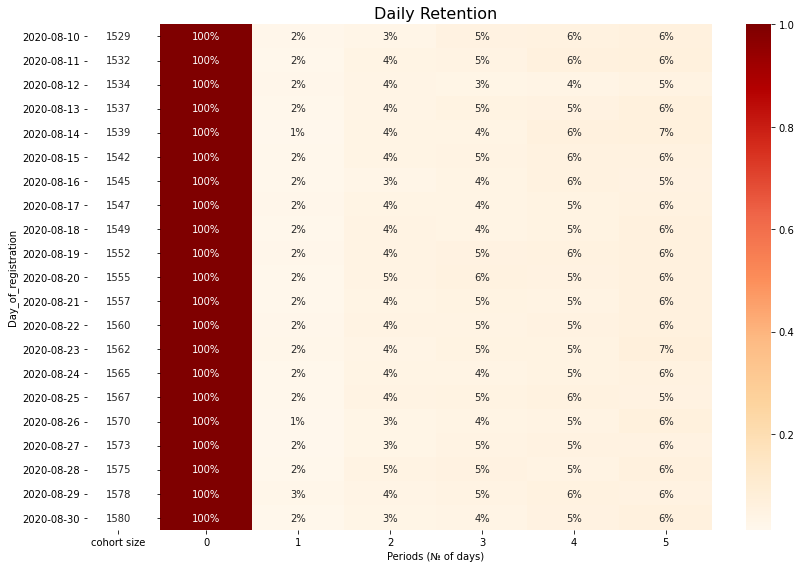

In [19]:
retention_ex=calculate_retention(reg_data, auth_data,from_date='2020-08-10', to_date='2020-08-30', ret_days=5)
retention_ex

# Задание 2. 
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [4]:
df=pd.read_csv('Проект_1_Задание_2.csv', sep=';')
df

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


In [6]:
df.shape

(404770, 3)

In [7]:
df.nunique()

user_id      404770
revenue        1477
testgroup         2
dtype: int64

In [8]:
df.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [9]:
df.describe()

,user_id,revenue
count,404770.000000,404770.000000
mean,202385.500000,26.083435
std,116847.178567,681.652928
min,1.000000,0.000000
25%,101193.250000,0.000000
50%,202385.500000,0.000000
75%,303577.750000,0.000000
max,404770.000000,37433.000000


провели первичный анализ данных, все пользователи уникальные, пропущенных данных нет, все супер
теперь нужно разделить по группам+по группам и те, кто вообще оплачивал что-то в играх

In [9]:
group_a=df.query('testgroup=="a"')
group_a

,user_id,revenue,testgroup
1,2,0,a
2,3,0,a
9,10,0,a
10,11,0,a
11,12,0,a
...,...,...,...
404760,404761,0,a
404762,404763,0,a
404765,404766,0,a
404767,404768,231,a


In [10]:
group_b=df.query('testgroup=="b"')
group_b

,user_id,revenue,testgroup
0,1,0,b
3,4,0,b
4,5,0,b
5,6,0,b
6,7,0,b
...,...,...,...
404761,404762,0,b
404763,404764,0,b
404764,404765,0,b
404766,404767,0,b


In [11]:
groupa_paid=group_a.query('revenue!=0')
groupa_paid

,user_id,revenue,testgroup
72,73,351,a
341,342,290,a
385,386,250,a
416,417,37324,a
712,713,255,a
...,...,...,...
404304,404305,360,a
404315,404316,262,a
404543,404544,369,a
404602,404603,251,a


In [12]:
groupb_paid=group_b.query('revenue!=0')
groupb_paid

,user_id,revenue,testgroup
160,161,3797,b
377,378,3768,b
386,387,3527,b
551,552,2038,b
913,914,3902,b
...,...,...,...
403843,403844,3383,b
403994,403995,2793,b
404161,404162,2316,b
404193,404194,2998,b


теперь нужно проверить, правильные ли вообще выводы по данным даны в задании

In [13]:
apru_a=groupa_paid.revenue.sum()/202103
apru_a

25.413719736965806

In [14]:
apru_b=groupb_paid.revenue.sum()/202667 
apru_b

26.75128659327863

In [15]:
dif_apru=((apru_a/apru_b * 100) - 100).round(0)
dif_apru

-5.0

arpu правда 5%!

мы знаем количество платящих в обеих группах - 1928 и 1805. Но нас интересуют именно платящие и вообще есть ли смысл в игре и в том что она есть: то есть сколько людей в ней платят. нужно посмотреть конверсию. 

In [16]:
conv_a=round(1928/202103, 5)
conv_b=round(1805/202667, 5)
print(conv_a, conv_b)

0.00954 0.00891


в контрольной группе конверсия в платящего больше. но нужно посмотреть вообще как люди платят. 

(array([1805.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         123.]),
 array([  200. ,  3923.3,  7646.6, 11369.9, 15093.2, 18816.5, 22539.8,
        26263.1, 29986.4, 33709.7, 37433. ]),
 <a list of 10 Patch objects>)

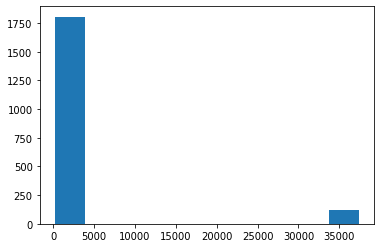

In [21]:
plt.hist(groupa_paid['revenue'])

(array([180., 172., 161., 201., 169., 188., 188., 208., 162., 176.]),
 array([2000., 2200., 2400., 2600., 2800., 3000., 3200., 3400., 3600.,
        3800., 4000.]),
 <a list of 10 Patch objects>)

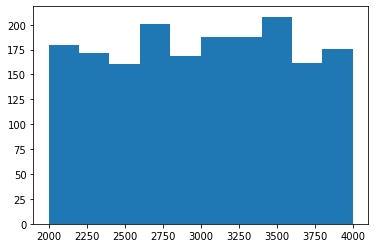

In [22]:
plt.hist(groupb_paid['revenue'])

так, ну какой можно сделать вывод посмотрев на распределение оплат? в контрольной группе (а) в основном покупают на маленькие суммы - до 5000 и только малое количество игроков потратило 35000, т.е. есть всего две платежные группы
в тестовой группе (б) намного больше платежных групп
нужно поработать с данными, чтобы понять, если в них вообще какая-то статистическая зависимость

In [26]:
# Расчет стандартного отклонения
std_control = np.std(groupa_paid['revenue'], ddof=1)
std_test = np.std(groupb_paid['revenue'], ddof=1)

print(f"Стандартное отклонение ARPU контрольной группы: {std_control:.2f}")
print(f"Стандартное отклонение ARPU тестовой группы: {std_test:.2f}")


Стандартное отклонение ARPU контрольной группы: 9049.04
Стандартное отклонение ARPU тестовой группы: 572.62


In [30]:
conversion_rates = successes / n
print(f"Конверсия группы A: {conversion_rates[0]:.4f}")
print(f"Конверсия группы B: {conversion_rates[1]:.4f}")


Конверсия группы A: 0.0095
Конверсия группы B: 0.0089


промежуточные вывод: во-первых, мы подтвердили что в тестовой группе больше вариантов групп платящих игроков, во-вторых, выявили, что есть статистически значимая разница в конверсиях.

давайте посмотрим еще поближе на контрольную группу. потому что вот эти ребята, которые покупают на 35000 как-то выглядят удивительно. посмотрим на ящики с усами

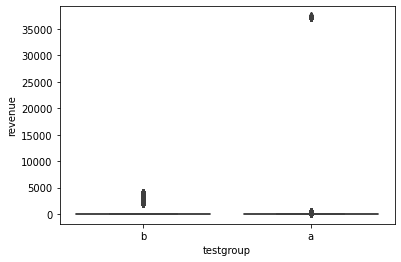

In [5]:
sns.boxplot(x="testgroup", y="revenue", data=df)

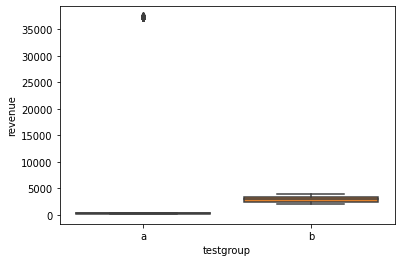

In [6]:
sns.boxplot(x="testgroup", y="revenue", data=df.query('revenue != 0'))

какой можно сделать вывод по графикам? 
в тестовой группе распределение равномерное, а в контрольной есть выбросы, из-за чего искажается среднее.

посмотрим на выбросы. 

In [17]:
groupa_paid.query('revenue > 30000')

,user_id,revenue,testgroup
416,417,37324,a
4428,4429,37304,a
5777,5778,37315,a
8065,8066,37307,a
8743,8744,37334,a
...,...,...,...
360696,360697,37347,a
378668,378669,37297,a
389341,389342,37298,a
394580,394581,37302,a


In [18]:
# Посмотрим какой процент платящих игроков совершили покупку от всех кто совершили покупку на сумму больше 30000

diff_control = (groupa_paid.query('revenue > 30000').shape[0]/ groupa_paid.query('revenue < 30000').shape[0] * 100)
diff_control = int(diff_control) 
print(f'{diff_control} % игрoков совершили покупку более чем на 30000')

6 % игрoков совершили покупку более чем на 30000


6 процентов/123 человека это как-то много для выброса, надо с этим разобраться

In [21]:
#проверим на нормальность дисперсии вообще
pg.homoscedasticity(data=df, dv="revenue", group="testgroup")

,W,pval,equal_var
levene,0.389629,0.532495,True


у данных нормальная дисперсия 

In [22]:
#проверим на нормальность дисперсии для платящих

pg.homoscedasticity(data=df.query('revenue != 0'), dv="revenue", group="testgroup")


,W,pval,equal_var
levene,80.855674,3.779690e-19,False


дисперсия не одинаковая!! треш. надо разбираться

In [24]:
#проверим на нормальность. Н0 данные нормально распределены

pg.normality(data=df, dv="revenue", group="testgroup", method="normaltest")

,W,pval,normal
b,326622.395409,0.0,False
a,585152.731273,0.0,False


Отклоняем H0. Данные распределены не нормально

In [25]:
#тест на нормальность для платящих.  Н0 данные нормально распределены
pg.normality(data=df.query('revenue != 0'), dv="revenue", group="testgroup", method="normaltest")

,W,pval,normal
a,1394.945784,1.234161e-303,False
b,1068.860008,7.943249e-233,False


Отклоняем H0. Данные распределены не нормально

In [27]:
successes = np.array([1928, 1805])  # Количество платящих пользователей
n = np.array([202103, 202667])  # Всего пользователей в группах

# Проведение теста пропорций
z_stat, p_value = proportions_ztest(successes, n)

# Результаты
print(f"Z-статистика: {z_stat:.4f}")
print(f"P-значение: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: есть статистически значимая разница в конверсиях.")
else:
    print("Не отвергаем нулевую гипотезу: нет статистически значимой разницы в конверсиях.")


Z-статистика: 2.1080
P-значение: 0.0350
Отвергаем нулевую гипотезу: есть статистически значимая разница в конверсиях.


In [28]:
#предлагаю посмотреть на группы через U-критерий Манна-Уитни, тк он не чувствителен к выбросам
mannwhitneyu(df[df.testgroup == 'a'].revenue, 
             df[df.testgroup == 'b'].revenue)

MannwhitneyuResult(statistic=20491259376.0, pvalue=0.06269701316074398)

ура! значимых отличий в выборках нет

In [32]:
groupa_paid.mean()

user_id    200152.677905
revenue      2663.998444
dtype: float64

In [33]:
groupb_paid.mean()

user_id    205834.548476
revenue      3003.658172
dtype: float64

In [34]:
groupa_paid.median()

user_id    199854.5
revenue       311.0
dtype: float64

In [35]:
groupb_paid.median()

user_id    206651.0
revenue      3022.0
dtype: float64

среднее у групп - 2663/3003
медиана - 311/3022
проверка на гомогенность+нормальность вывела, что дисперсии в группах разные и распределение не нормально, так что Т-тест не подходит
можно проверить нулевую гипотезу про равенство медиан через бутстрап(из-за выбросов)

In [43]:
#сделаем функцию для бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

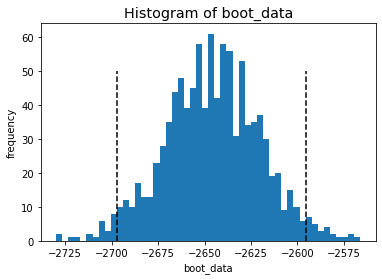

In [44]:
booted_data_median = get_bootstrap(groupa_paid.revenue, groupb_paid.revenue, statistic = np.median)


In [45]:
booted_data_median["p_value"]

0.0

In [46]:
booted_data_median['ci'] 

,0
0.025,-2697.0
0.975,-2595.5


доверительный интервал не включает 0, так что есть статзначимые отличия в медианах

результат: несмотря на то, что конверсия в платящего игрока статистически значима и больше у контрольной группы, тестовая группа имеет намного лучше показатели по медиане ревенью. берется медиана потому что существуют выбросы внутри данных
тестовая группа показала себя намного лучше. медиана у платящих в контрольной группе - 311, а в тестовой - 3022. Так что тестовая группа показала себя лучше. 

для дальнейшей работы я бы рассмотрела еще детальнее контрольную группу, потому что группа, которая заплатила в игру больше 30000, выглядит как выброс и надо понять, почему она вообще такая там существует.

# Задание 3.

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?


Пункт 1. 
ретеншн 
дау и вау - ежедевные/еженедельные активные пользователи
средний чек на игрока ARPU
Уровень вовлеченности: Например, можно отслеживать, сколько игроков начали событие и сколько из них его завершили.

количество игроков, которые посетили событие: первая и главная метрика. нужно посмотреть, сколько игроков вообще участвуют в событиях, а не игнорируют их и просто продолжают играть в обычные уровни игры. Это поможет посмотреть заинтересованность игроков вообще в такого рода спец событиях 

Retention по событию: посмотреть, сколько игроков продолжают активно участвовать в событиях 

unique players of event: разделить уникальных игроков на две кагорты: только зашли в игру и это их первое событие/давно играют, но решили поучаствовать именно в этом событии. вторую группу можно дополнительно проанализировать и посмотреть почему именно это событие заинтересовало 

Number of unique players per event - первая метрика от которой нужно отталкиваться, это количество уникальных игроков которые посетили данную акцию. Сравнивать с предыдущими тематическими событиями. Это необходимо для понимания общей динамики событий.
retention: посмотреть вообще ежедневный ретеншн и проверить, насколько событие влияет на вхождение игроков в игру. возможно события мотивируют чаще приходить и играть 

dau: похожая ситуация с ретеншеном, возможно количество ежедневно активных игроково с началом события будет влиять на количество ежедневных активных польххователей

средний чек на игрока ARPU: посмотреть, влияет ли наличие события на увеличение среднего дохода - тут может быть две теории 1. чтобы проходить событие, игроки покупают бусты/монеты 2. тк игроки проходят событие, но при этом не хотят терять скорость в обычных уровнях, они покупают дополнительно бусты/монеты, чтобы не терять скорость прохождения

level retention: насколько игрокам вообще интересно проходить уровни. поможет проверить замотивированность в прохождении события и даст возможность посмотреть, где игроки перестают проходить - возможно это поможет смодифицировать следующие события, чтобы больше человек доходили до конца/замотивировать их покупать больше бустов, чтобы проходить дальше по уровням

количество заработанных монет: можно посмотреть, насколько успешным+нужным для игрока было событие. если игрок много получил, то у него растет мотивация дальше играть - он же не зря заработал эти монеты+проходил событие. влияет на ретеншн игроков



Пункт 2. 

так как это механика сильно влияет на игровой процесс и может влиять на восприятие игры, сначала нужно посмотреть на вот эти метрики: 

retention по уровням: нужно проверить, насколько влияет откат на уровни назад на возвращение в игру. Тк это довольно агрессивная механика, она может влиять на желание продолжать играть, так что нужно проверить, сколько игроков несмотря на это продолжили проходить событие

количество купленных бустеров/потраченных монет: это может работать в две стороны - игрок будет бояться отката на уровни назад, что будет мотивировать его покупать бустеры чтобы не потерять уже пройденное/игрок будет откатываться назад и тк он не захочет заново сильно вовлекаться в уже пройденное он будет покупать бустеры, чтобы быстрее пройти уже пройденные ранее уровни и перейти к новым

Churn Rate: насколько такая агрессивная механика может уменьшать количество участников в игре вообще: user story "вот блин я хотел пройти и получить бонусы, но игра как-то странно устроена сейчас, поэтому больше не буду в нее играть, потому что так не прикольно"

Session Duration: чем дольше человек проходит уровни, тем больше времени он тратит в игре. Если его откидывает на уровни назад при проигрыше, а он хочет получить бонусы за событие, он будет пытаться еще раз проходить уровни. Чем больше времени игрок проводит в игре, тем больше вероятность, что он потрати денег/принесет денег, посмотрев какую-то рекламу

